In [29]:
!pip3 install handyspark

In [3]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [4]:
import random, os
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from pyspark.sql import SparkSession

In [7]:
#from LC_Helper import vectorizerFunction, SmoteSampling

In [8]:
spark = SparkSession\
    .builder\
    .appName("Baseline_Model")\
    .config("spark.hadoop.fs.s3a.s3guard.ddb.region","us-east-2")\
    .config("spark.yarn.access.hadoopFileSystems",os.environ["STORAGE"])\
    .getOrCreate()

Setting spark.hadoop.yarn.resourcemanager.principal to pauldefusco


In [9]:
df = spark.sql("SELECT * FROM default.lc_smote_subset")

Hive Session ID = 86080ed9-7ea4-4ef7-be50-1ecd1202c69c


In [10]:
#Creating list of categorical and numeric features
num_cols = [item[0] for item in df.dtypes if item[1].startswith('in') or item[1].startswith('dou')]

In [11]:
df = df.dropna()

In [12]:
df = df.select(['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt', 'is_default'])

In [13]:
train = df.sampleBy("is_default", fractions={0: 0.8, 1: 0.8}, seed=10)

In [14]:
test = df.subtract(train)

Creating Model Pipeline

In [15]:
#Creates a Pipeline Object including One Hot Encoding of Categorical Features  
def make_pipeline(spark_df):        
     
    for c in spark_df.columns:
        spark_df = spark_df.withColumn(c, spark_df[c].cast("float"))
    
    stages= []

    cols = ['acc_now_delinq', 'acc_open_past_24mths', 'annual_inc', 'avg_cur_bal', 'funded_amnt']
    
    #Assembling mixed data type transformations:
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    stages += [assembler]    
    
    #Scaling features
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)
    stages += [scaler]
    
    #Logistic Regression
    lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='is_default', maxIter=10, regParam=0.1, elasticNetParam=0.1)
    stages += [lr]
    
    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)

    return pipelineModel

In [16]:
pipelineModel = make_pipeline(train)

In [17]:
for c in test.columns:
    test = test.withColumn(c, test[c].cast("float"))

In [18]:
df_model = pipelineModel.transform(test)

In [19]:
df_model.columns

['acc_now_delinq',
 'acc_open_past_24mths',
 'annual_inc',
 'avg_cur_bal',
 'funded_amnt',
 'is_default',
 'features',
 'scaledFeatures',
 'rawPrediction',
 'probability',
 'prediction']

In [20]:
input_data = df_model.rdd.map(lambda x: (x["is_default"], x["prediction"], float(x["probability"][1])))

In [21]:
predictions = spark.createDataFrame(input_data, ["is_default", "prediction", "probability"])

In [22]:
predictions.dtypes

[('is_default', 'double'), ('prediction', 'double'), ('probability', 'double')]

In [23]:
df_model.select()

DataFrame[]

#### Baseline Model

In [24]:
df_model.select("is_default", "prediction").groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  293|
|       1.0|    1|
+----------+-----+



In [25]:
df_model.select("is_default", "prediction").groupby('is_default').count().show()

+----------+-----+
|is_default|count|
+----------+-----+
|       1.0|  107|
|       0.0|  187|
+----------+-----+



Model Evaluation

In [26]:
evaluator = BinaryClassificationEvaluator(labelCol="is_default", rawPredictionCol="prediction")

In [27]:
auroc = evaluator.evaluate(df_model, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(df_model, {evaluator.metricName: "areaUnderPR"})

In [28]:
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.4973
Area under PR Curve: 0.1820


In [30]:
# Handy Spark Library 
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(df_model, scoreCol='probability', labelCol='is_default')

/home/cdsw/.local/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


/home/cdsw/.local/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


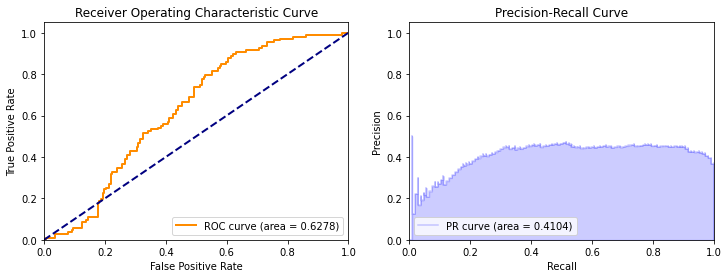

In [31]:
# Now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])
plt.show()

In [32]:
# And get the confusion matrix for any threshold we want
y_true = df_model.select(['is_default']).collect()
y_pred = df_model.select(['prediction']).collect()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.63      0.99      0.77       187
         1.0       0.00      0.00      0.00       107

    accuracy                           0.63       294
   macro avg       0.32      0.50      0.39       294
weighted avg       0.40      0.63      0.49       294



In [41]:
#Saving predictions

In [33]:
predictions\
  .write.format("parquet")\
  .mode("overwrite")\
  .saveAsTable(
    'default.LC_predictions'
)

In [34]:
train\
  .write.format("parquet")\
  .mode("overwrite")\
  .saveAsTable(
    'default.LC_train'
)

In [35]:
test\
  .write.format("parquet")\
  .mode("overwrite")\
  .saveAsTable(
    'default.LC_test'
)

In [36]:
#Saving pipeline to S3:
pipelineModel.write().overwrite().save(os.environ["STORAGE"]+"/pdefusco/pipeline")

In [37]:
spark.stop()